# Lab Work 5 (Student version): label propagation algorithm  

## Students:
## Jack Thay - 21201079
## Thierry Ung - 3804472


We can use the following libraries.

In [1]:
import matplotlib.pyplot as plt
import math
import sys
import random
import time
import numpy as np
from collections import defaultdict # Used as a dictionary of lists to store data
print(sys.version)

3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]


In [2]:
# Code taken from our TP1

def load_graph(filename):
    # Initialize an empty dictionary for the adjacency list.
    adjacency_list = {}
    
    # Open the specified file for reading.
    with open(filename, 'r') as file:
        # Loop through each line in the file.
        for line in file:
            # Check if the line does not start with '#' (comments)
            if not line.startswith('#'):
                # Split the line into two nodes representing an edge.
                edge_info = line.strip().split()
                node1, node2 = edge_info[0], edge_info[1]
                # Check if node1 is not already in the adjacency list.
                if node1 not in adjacency_list:
                    # Initialize an empty list for node1 in the adjacency list.
                    adjacency_list[node1] = []
                # Check if node2 is not already in the adjacency list.
                if node2 not in adjacency_list:
                    # Initialize an empty list for node2 in the adjacency list.
                    adjacency_list[node2] = []
                # Add node2 to the adjacency list of node1 (representing an undirected edge).
                adjacency_list[node1].append(node2)
                # Add node1 to the adjacency list of node2 (since it's an undirected edge).
                adjacency_list[node2].append(node1)

    # Return the adjacency list representing the undirected graph.
    return adjacency_list

### Question 1

We remind here the Label Propagation algorithm described in the course:

* 1. initialization: give a unique label to each node in the network

* 2. Arrange the nodes in the network in a random order

* 3. For each node in the network in this random order set its label to the majority label among its neighbours (in case of ties, decide randomly)

* 4. Go back to step 2 and iterate until all nodes have a label corresponding to the highest frequency in their neiborhood.

Implement this algorithm, the output is a table with the community of each node.

Apply it to the CAIDA dataset on Moodle.

In [3]:
def init_assignment(node_ids, community_assignment):
    # Initialize community assignment for each node with its own ID
    for node_id in node_ids:
        community_assignment[node_id] = node_id

In [4]:
def get_frequencies_labels(neighbours, community_assignment):
    # Initialize an empty dictionary to store frequencies of labels
    frequencies_labels = {}

    # Iterate through neighbors and update label frequencies
    for neighbour in neighbours:
        neighbour_label = community_assignment[neighbour]

        # Check if the label is already in the dictionary, if not, initialize it
        if neighbour_label not in frequencies_labels:
            frequencies_labels[neighbour_label] = 0

        # Increment the frequency count for the current label
        frequencies_labels[neighbour_label] += 1

    # Return the dictionary containing label frequencies
    return frequencies_labels

In [5]:
def convert_to_adjacency(adjacency_matrix, size):
    # Get the indices of non-zero elements in the adjacency matrix
    col, row = adjacency_matrix.nonzero()

    # Initialize an empty dictionary to represent the adjacency list
    my_graph = {}

    # Initialize the keys in the dictionary for each node in the graph
    for i in range(size):
        my_graph[i] = []

    # Populate the adjacency list by iterating through non-zero elements
    for i in range(len(col)):
        # Add the 'row' value as a neighbor to the 'col' node
        my_graph[col[i]].append(row[i])

    # Return the final adjacency list representation of the graph
    return my_graph

In [6]:
def label_propagation(adjacency_list):
    # Step 1: Initialize community assignments for each node
    community_assignment = {}
    node_ids = list(adjacency_list.keys())
    init_assignment(node_ids, community_assignment)

    # Flag to check if the algorithm has converged
    end = False

    # Continue label propagation until convergence
    while not end:
        # Step 2: Randomly shuffle node IDs for better convergence
        random.shuffle(node_ids)

        # Step 3: Propagate labels based on neighbor frequencies
        for node_id in node_ids:
            neighbours = adjacency_list[node_id]
            frequencies_labels = get_frequencies_labels(neighbours, community_assignment)

            # Update node's community assignment with the label having maximum frequency
            if len(frequencies_labels) > 0:
                max_frequency_label = max(frequencies_labels, key=frequencies_labels.get)
                community_assignment[node_id] = max_frequency_label

        # Check for convergence by comparing current labels with neighbor labels
        for node_id in node_ids:
            node_label = community_assignment[node_id]
            neighbours = adjacency_list[node_id]
            frequencies_labels = get_frequencies_labels(neighbours, community_assignment)

            # If a node's label is not the most frequent label among neighbors, continue iteration
            if len(frequencies_labels) > 0:
                max_frequency_label = max(frequencies_labels, key=frequencies_labels.get)
                if node_label != max_frequency_label:
                    end = False
                    break
                else:
                    end = True

    # Return the final community assignments
    return community_assignment

In [7]:
filename = "as_caida.txt"
caida_graph = load_graph(filename)

In [8]:
caida_community_assignment = label_propagation(caida_graph)

### Question 2

Compute and plot the distribution of the community sizes that you obtained.

Comment the distribution: its shape and what it reveals about the communities detected by the LP algorithm.

In [9]:
# Create a defaultdict to store community sizes, initializing with default value 0
community_sizes = defaultdict(int)

# Iterate through nodes and their corresponding community assignments
for node, community in caida_community_assignment.items():
    # Increment the size count for the community to which the node belongs
    community_sizes[community] += 1

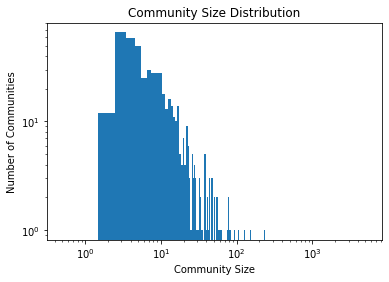

In [10]:
# Get the counts of community sizes
size_counts = list(community_sizes.values())

# Create a histogram of community sizes
plt.hist(size_counts, bins=range(1, max(size_counts) + 2), align='left')

# Set scale
plt.xscale("log")
plt.yscale("log")

# Set labels and title
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.title('Community Size Distribution')

# Show the plot
plt.show()

### Question 3

We remind you of the definition of the modularity score:

$$ Q = \frac{1}{2m} \sum_{i = 1}^{k}  \sum_{u \in S_i} d(u)_{in} -  \frac{vol(S_i)^2}{ 2m } $$

where 

* $d(u)_{in}$ is the part if the degree of node $u$ that goes to nodes in $ S_i $

* $vol(S_i) = \sum_{u \in S_i} d(u)$ is the sum of the degree of a node inside a community

Compute the modularity of the result of LP algorithm on Erdös-Rényi graphs of various densities to check if the results seem consistent.

In [11]:
def generate_erdos_renyi(n, p):
    # Initialize an empty graph represented as an adjacency list
    graph = {}
    
    # Create nodes in the graph
    for i in range(n):
        graph[i] = []
    
    # Iterate through pairs of nodes and add edges based on probability 'p'
    for i in range(n):
        for j in range(i+1, n):  
            # Check if a random number is less than 'p' to determine if an edge is added
            if random.random() < p:
                # Add edges between nodes i and j in both directions
                graph[i].append(j)
                graph[j].append(i)
    
    # Return the generated Erdos-Renyi graph
    return graph

In [12]:
def modularity(graph, community_assignment):
    # Get the number of nodes and calculate the total number of edges (m)
    n = len(graph)
    m = sum(len(neighbors) for neighbors in graph.values()) // 2

    # Initialize lists to store in-degrees and volumes of communities
    in_degree = [0] * n
    vol_communities = [0] * n  

    # Iterate through nodes and update in-degrees and community volumes
    for node, neighbors in graph.items():
        community = community_assignment[node]
        in_degree[node] += len([n for n in neighbors if community_assignment[n] == community])
        vol_communities[community] += len(neighbors)

    # Calculate modularity (Q) using the defined formula
    Q = 0
    for node, community in enumerate(community_assignment):
        d_in = in_degree[node]
        vol_c = vol_communities[community]
        Q += d_in - (vol_c**2) / (2*m)

    # Calculate Qmax and Qmin for normalization
    Qmax = 0
    Qmin = 0  
    for v in vol_communities:
        Qmax += v**2 / (2*m)
        Qmin -= v**2 / (2*m)

    # Normalize Q and ensure it is within the range [-1, 1]
    Q = Q / Qmax  
    Q = max(min(Q, 1), -1)

    # Return the normalized modularity
    return Q

In [13]:
# Iterate over different values of edge probability 'p' in Erdos-Renyi graphs
for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    # Generate an Erdos-Renyi graph with 100 nodes and edge probability 'p'
    graph = generate_erdos_renyi(100, p)

    # Apply label propagation algorithm to detect communities
    community_assignment = label_propagation(graph)

    # Calculate and print the modularity of the detected communities
    print("Modularity:", modularity(graph, community_assignment))

Modularity: 0.0
Modularity: 0.0
Modularity: 0.0
Modularity: 0.0
Modularity: 0.0
Modularity: 0.0
Modularity: 0.0
Modularity: 0.0
Modularity: 0.0
Modularity: 0.0


### Answer :  
We use min-max for the modularity, the result are rounded, so we can only have -1, 0 and 1.  
Here we have 0, it suggests that the observed network's community structure is not significantly different from what would be expected in a random network. The network does not exhibit a clear community structure. The divisions between communities are not more pronounced than what one would expect by random chance.

### Question 4

Compute the modularity of the partition that you obtained.

Make several other realizations of the LP algorithm on CAIDA and comment the results and range of values.

In [14]:
def caida_init_assignment(node_ids, community_assignment):
    # Initialize community assignment for each node with its own ID (converted to integer)
    for node_id in node_ids:
        community_assignment[node_id] = int(node_id)

In [15]:
def caida_get_frequencies_labels(neighbours, community_assignment):
    # Initialize a dictionary to store frequencies of labels among neighbors
    frequencies = {}

    # Iterate through neighbors and update label frequencies
    for neighbor in neighbours:
        neighbor = str(neighbor)  # Convert the neighbor key to a string
        label = community_assignment.get(neighbor)

        # Update the frequency count for the current label
        if label is not None:
            frequencies[label] = frequencies.get(label, 0) + 1

    # Return the dictionary containing label frequencies
    return frequencies

In [16]:
def caida_label_propagation(adjacency_list):
    # Initialize community assignments for each node based on its own ID
    community_assignment = {}
    node_ids = list(adjacency_list.keys())
    caida_init_assignment(node_ids, community_assignment)

    # Flag to check if the label propagation algorithm has converged
    end = False

    # Continue label propagation until convergence
    while not end:
        # Step 1: Randomly shuffle node IDs for better convergence
        random.shuffle(node_ids)

        # Step 2: Propagate labels based on neighbor frequencies
        for node_id in node_ids:
            neighbours = adjacency_list[node_id]
            frequencies_labels = caida_get_frequencies_labels(neighbours, community_assignment)

            # Update node's community assignment with the label having maximum frequency
            if len(frequencies_labels) > 0:
                max_frequency_label = max(frequencies_labels, key=frequencies_labels.get)
                community_assignment[node_id] = int(max_frequency_label)

        # Step 3: Check for convergence by comparing current labels with neighbor labels
        for node_id in node_ids:
            node_label = community_assignment[node_id]
            neighbours = adjacency_list[node_id]
            frequencies_labels = caida_get_frequencies_labels(neighbours, community_assignment)

            # If a node's label is not the most frequent label among neighbors, continue iteration
            if len(frequencies_labels) > 0:
                max_frequency_label = max(frequencies_labels, key=frequencies_labels.get)
                if node_label != int(max_frequency_label):
                    end = False
                    break
                else:
                    end = True

    # Return the final community assignments
    return community_assignment

In [17]:
def caida_modularity(graph, community_assignment):
    # Find the maximum node ID in the graph
    max_node_id = max(map(int, graph.keys()))

    # Initialize lists to store in-degrees and community volumes
    in_degree = [0] * (max_node_id + 1)
    max_community = max(community_assignment.values())
    vol_communities = [0] * (max_community + 1)

    # Get the number of nodes and calculate the total number of edges (m)
    n = len(graph)
    m = sum(len(neighbors) for neighbors in graph.values()) // 2

    # Iterate through nodes and update in-degrees and community volumes
    for node, neighbors in graph.items():
        node_int = int(node)
        community = community_assignment[int(node_int)]

        # Update in-degree for the current node
        in_degree[node_int] += len([n for n in neighbors
                                    if community_assignment[int(n)] == community])

        # Update community volume for the current community
        vol_communities[community] += len(neighbors)

    # Calculate modularity (Q) using the defined formula
    Q = 0
    for node_int, community in enumerate(community_assignment.values()):
        d_in = in_degree[node_int]
        vol_c = vol_communities[community]
        Q += d_in - (vol_c**2) / (2 * m)

    # Calculate Qmax and Qmin for normalization
    Qmax = 0
    Qmin = 0
    for v in vol_communities:
        Qmax += v**2 / (2 * m)
        Qmin -= v**2 / (2 * m)

    # Normalize Q and ensure it is within the range [-1, 1]
    Q = Q / Qmax
    Q = max(min(Q, 1), -1)

    # Return the normalized modularity
    return Q

In [18]:
filename = "as_caida.txt"
caida_graph = load_graph(filename)

In [19]:
caida_community_assignment = caida_label_propagation(caida_graph)

In [20]:
caida_graph1 = {int(k):v for k,v in caida_graph.items()}

caida_community_assignment1 = {int(k):v for k,v in caida_community_assignment.items()}


In [21]:
caida_community_assignment1

{1: 2,
 2: 2,
 3: 2,
 4: 4,
 30: 30,
 43: 43,
 82: 82,
 90: 43,
 95: 95,
 292: 292,
 618: 2,
 642: 642,
 699: 2,
 706: 706,
 712: 43,
 762: 2,
 951: 2,
 964: 2,
 991: 991,
 1053: 1053,
 1067: 2,
 1124: 2,
 1188: 2,
 1502: 1502,
 1503: 1503,
 1682: 2,
 2015: 2015,
 2020: 2020,
 2310: 2,
 2501: 95,
 2529: 2,
 2770: 2770,
 3084: 43,
 3158: 2,
 3423: 2,
 3456: 2,
 3489: 2,
 3542: 2,
 3593: 3593,
 3636: 792,
 3658: 2,
 3683: 3683,
 3684: 2,
 3706: 2,
 3712: 2,
 3729: 2,
 3921: 3921,
 3928: 2,
 4114: 292,
 4155: 217,
 4156: 2,
 4318: 2,
 4319: 4319,
 4479: 2,
 4482: 2,
 4622: 2,
 4742: 2,
 5015: 2,
 5059: 5059,
 5368: 2,
 6165: 2,
 6232: 2,
 6235: 2,
 6295: 6295,
 6314: 2,
 6422: 2,
 6498: 2,
 8740: 2,
 8751: 2,
 8819: 2,
 8844: 2,
 8852: 2,
 8890: 2,
 8895: 2,
 9680: 2,
 10172: 10172,
 10969: 2,
 11012: 2,
 11512: 2,
 11525: 2,
 11612: 2,
 11627: 2,
 11633: 2,
 12637: 43,
 12787: 2,
 12845: 2,
 12846: 2,
 12865: 2,
 12875: 2,
 12880: 2,
 12949: 2,
 13020: 2,
 13060: 2,
 13247: 2,
 13253: 2,

In [22]:
caida_modularity(caida_graph1, caida_community_assignment1)


-1

In [23]:
filename = "as_caida.txt"
caida_graph2 = load_graph(filename)

In [24]:
caida_community_assignment2 = caida_label_propagation(caida_graph2)

In [25]:
caida_graph3 = {int(k):v for k,v in caida_graph2.items()}

caida_community_assignment3 = {int(k):v for k,v in caida_community_assignment2.items()}

In [26]:
caida_community_assignment3

{1: 2,
 2: 2,
 3: 2,
 4: 4,
 30: 30,
 43: 43,
 82: 82,
 90: 90,
 95: 95,
 292: 292,
 618: 2,
 642: 642,
 699: 2,
 706: 706,
 712: 18,
 762: 2,
 951: 951,
 964: 18,
 991: 2,
 1053: 1053,
 1067: 2,
 1124: 2,
 1188: 2,
 1502: 1502,
 1503: 1503,
 1682: 2,
 2015: 2,
 2020: 2,
 2310: 2,
 2501: 95,
 2529: 2,
 2770: 2770,
 3084: 18,
 3158: 18,
 3423: 2,
 3456: 2,
 3489: 2,
 3542: 2,
 3593: 2,
 3636: 792,
 3658: 2,
 3683: 3683,
 3684: 2,
 3706: 2,
 3712: 2,
 3729: 2,
 3921: 3921,
 3928: 2,
 4114: 2,
 4155: 2,
 4156: 2,
 4318: 2,
 4319: 4319,
 4479: 2,
 4482: 2,
 4622: 2,
 4742: 2,
 5015: 2,
 5059: 2,
 5368: 2,
 6165: 2,
 6232: 6232,
 6235: 2,
 6295: 6295,
 6314: 2,
 6422: 2,
 6498: 2,
 8740: 2,
 8751: 2,
 8819: 2,
 8844: 2,
 8852: 2,
 8890: 2,
 8895: 2,
 9680: 2,
 10172: 10172,
 10969: 2,
 11012: 2,
 11512: 2,
 11525: 2,
 11612: 2,
 11627: 18,
 11633: 2,
 12637: 18,
 12787: 2,
 12845: 2,
 12846: 2,
 12865: 2,
 12875: 2,
 12880: 2,
 12949: 2,
 13020: 2,
 13060: 2,
 13247: 2,
 13253: 2,
 13523: 2

In [27]:
caida_modularity(caida_graph3, caida_community_assignment3)


-1

In [28]:
filename = "as_caida.txt"
caida_graph4 = load_graph(filename)

In [29]:
caida_community_assignment4 = caida_label_propagation(caida_graph4)

In [30]:
caida_graph5 = {int(k):v for k,v in caida_graph4.items()}

caida_community_assignment5 = {int(k):v for k,v in caida_community_assignment4.items()}

In [31]:
caida_community_assignment5

{1: 2,
 2: 2,
 3: 2,
 4: 4,
 30: 30,
 43: 43,
 82: 82,
 90: 90,
 95: 95,
 292: 2,
 618: 2,
 642: 642,
 699: 2,
 706: 706,
 712: 18,
 762: 2,
 951: 2,
 964: 18,
 991: 991,
 1053: 1053,
 1067: 2,
 1124: 2,
 1188: 2,
 1502: 2,
 1503: 1503,
 1682: 2,
 2015: 2015,
 2020: 2,
 2310: 2,
 2501: 95,
 2529: 2,
 2770: 18,
 3084: 2,
 3158: 18,
 3423: 2,
 3456: 2,
 3489: 2,
 3542: 2,
 3593: 2,
 3636: 2,
 3658: 2,
 3683: 2,
 3684: 2,
 3706: 2,
 3712: 2,
 3729: 2,
 3921: 3921,
 3928: 2,
 4114: 2,
 4155: 18,
 4156: 2,
 4318: 2,
 4319: 4319,
 4479: 2,
 4482: 2,
 4622: 2,
 4742: 2,
 5015: 2,
 5059: 5059,
 5368: 2,
 6165: 2,
 6232: 6232,
 6235: 2,
 6295: 6295,
 6314: 2,
 6422: 2,
 6498: 2,
 8740: 8740,
 8751: 2,
 8819: 2,
 8844: 2,
 8852: 2,
 8890: 2,
 8895: 2,
 9680: 2,
 10172: 10172,
 10969: 2,
 11012: 2,
 11512: 2,
 11525: 2,
 11612: 2,
 11627: 2,
 11633: 2,
 12637: 18,
 12787: 2,
 12845: 2,
 12846: 2,
 12865: 2,
 12875: 2,
 12880: 2,
 12949: 2,
 13020: 2,
 13060: 2,
 13247: 2,
 13253: 2,
 13523: 2,
 1

In [32]:
caida_modularity(caida_graph5, caida_community_assignment5)

-1

### Answer :  
Here the modularity is equal to -1, it indicates that the observed network structure is opposite to the expected community structure in a random network. It implies that the chosen partition of nodes into communities is worse than what would be expected by random chance.

### Question 5

Run the LP algorithm on the various undirected graphs that you have (for instance INET, Amazon), compute the modularity and comment. 

In [33]:
filename = "ip_inet.txt"
inet_graph = load_graph(filename)

In [34]:
inet_community_assignment = caida_label_propagation(inet_graph)

In [35]:
inet_graph2 = {int(k):v for k,v in inet_graph.items()}

inet_community_assignment2 = {int(k):v for k,v in inet_community_assignment.items()}

In [36]:
inet_community_assignment2

{0: 0,
 1882: 0,
 7203: 0,
 5853: 768,
 6239: 0,
 1: 1007,
 1007: 1007,
 2: 7880,
 7880: 7880,
 7881: 7880,
 7882: 7880,
 7878: 7880,
 7879: 7880,
 3: 3,
 17: 3,
 4: 3,
 6: 3,
 5: 3,
 7: 3,
 8: 3,
 9: 3,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 15: 3,
 16: 3,
 4805: 3,
 14: 3,
 18: 3,
 4801: 3,
 19: 19,
 25: 19,
 3178: 19,
 3180: 26,
 3242: 19,
 20: 3253,
 3253: 3253,
 23: 20,
 21: 3182,
 3182: 3182,
 22: 3250,
 3250: 3250,
 3236: 3250,
 3235: 20,
 3177: 3177,
 3179: 20,
 3256: 20,
 24: 24,
 3252: 24,
 3246: 24,
 26: 26,
 27: 26,
 28: 26,
 29: 26,
 30: 34,
 34: 34,
 36: 34,
 31: 34,
 32: 34,
 33: 34,
 35: 34,
 37: 34,
 38: 34,
 46: 36,
 44: 36,
 39: 34,
 47: 34,
 40: 36,
 41: 36,
 42: 36,
 43: 36,
 45: 36,
 3091: 2716,
 48: 50,
 50: 50,
 49: 67,
 67: 67,
 68: 67,
 69: 67,
 51: 67,
 60: 67,
 77: 51,
 52: 51,
 53: 51,
 54: 62,
 73: 62,
 55: 67,
 56: 67,
 70: 67,
 57: 67,
 59: 67,
 58: 67,
 64: 67,
 61: 67,
 62: 62,
 72: 62,
 74: 62,
 4204: 62,
 63: 67,
 65: 65,
 4200: 65,
 4201: 65,
 4202: 65,
 

In [37]:
caida_modularity(inet_graph2, inet_community_assignment2)

1

### Answer :  
Here the modularity is equal to 1, it indicates a highly modular network with well-defined and distinct communities. Nodes within communities are densely connected while connections between communities are minimized.

In [38]:
filename = "com-amazon.ungraph.txt"
amazon_graph = load_graph(filename)

In [39]:
amazon_community_assignment = caida_label_propagation(amazon_graph)

In [40]:
amazon_graph2 = {int(k):v for k,v in amazon_graph.items()}

amazon_community_assignment2 = {int(k):v for k,v in amazon_community_assignment.items()}

In [41]:
amazon_community_assignment2

{1: 1,
 88160: 1,
 118052: 1,
 161555: 1,
 244916: 1,
 346495: 1,
 444232: 1,
 447165: 1,
 500600: 1,
 2: 62291,
 27133: 62291,
 62291: 62291,
 170507: 62291,
 299250: 62291,
 326776: 62291,
 331042: 62291,
 411179: 62291,
 451149: 62291,
 454888: 62291,
 4: 16050,
 16050: 16050,
 286286: 16050,
 310803: 16050,
 320519: 16050,
 408108: 16050,
 448284: 16050,
 5: 5,
 173362: 5,
 305321: 5,
 407216: 5,
 489756: 5,
 6: 162248,
 162248: 162248,
 298989: 4832,
 398542: 162248,
 495077: 4832,
 7: 30028,
 30028: 30028,
 47672: 30028,
 355935: 30028,
 8: 8,
 10758: 8,
 55461: 8,
 60605: 8,
 148586: 8,
 184847: 8,
 242156: 201353,
 445607: 8,
 453513: 8,
 10: 80558,
 80558: 80558,
 192929: 80558,
 266485: 80558,
 500235: 80558,
 504757: 80558,
 11: 3427,
 57761: 25878,
 107436: 3427,
 400957: 3427,
 512424: 167439,
 12: 12,
 386032: 12,
 15: 15,
 67084: 15,
 85444: 15,
 252980: 15,
 422732: 15,
 425706: 15,
 428290: 15,
 16: 128935,
 128935: 128935,
 148997: 15148,
 422237: 72326,
 17: 18919,
 

In [42]:
caida_modularity(amazon_graph2, amazon_community_assignment2)

1

### Answer :  
Here the modularity is equal to 1, it indicates a highly modular network with well-defined and distinct communities. Nodes within communities are densely connected while connections between communities are minimized.